# Prediction intervals

When trying to anticipate future values, the majority of forecasting models try to predict what will be the most likely value, this is call point-forecasting. Although knowing in advance the expected value of a time series is useful in almost every business case, this kind of prediction does not provide any information about the confidence of the model nor the uncertainty in the prediction.

Probabilistic forecasting, as opposed to point-forecasting, is a family of techniques that allow predicting the expected distribution function instead of a single future value. This type of forecasting provides much rich information since it allows to create prediction intervals, the range of likely values where the true value may fall. More formally, a prediction interval defines the interval within which the true value of the response variable is expected to be found with a given probability.

In the book Forecasting: Principles and Practice, Rob J Hyndman and George Athanasopoulos list [multiple ways to estimate prediction intervals](https://otexts.com/fpp3/prediction-intervals.html), most of which require that the residuals (errors) of the model follow a normal distribution. When this property cannot be assumed, bootstrapping can be resorted to, which only assumes that the residuals are uncorrelated. This is the method used in skforecast.

<p align="center"><img src="../img/diagram-bootstrapping-prediction-intervals.png" style="width: 700px;"></p>

<p align="center"><img src="../img/diagram-bootstrapping-prediction-intervals-2.png" style="width: 700px;"></p>

<p align="center"><img src="../img/forecasting-intervals.gif" style="width: 900px;"></p>

## Libraries

In [1]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import Ridge

## Data

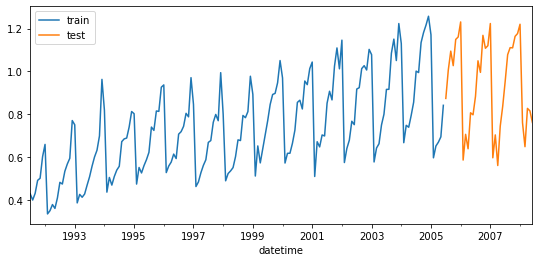

In [2]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y/%m/%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Split train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.legend();

## Prediction intervals

In [3]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = Ridge(),
                lags      = 15
             )

forecaster.fit(y=data_train)
forecaster

ForecasterAutoreg 
Regressor: Ridge() 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Window size: 15 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001} 
Creation date: 2022-03-12 12:08:52 
Last fit date: 2022-03-12 12:08:52 
Skforecast version: 0.4.3 

In [4]:
# Prediction intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                    steps    = 36,
                    interval = [5, 95],
                    n_boot   = 250
              )

predictions.head(4)

,pred,lower_bound,upper_bound
2005-07-01,0.973131,0.876141,1.068890
2005-08-01,1.022154,0.926207,1.130223
2005-09-01,1.151334,1.050965,1.261538
2005-10-01,1.206401,1.109054,1.303380


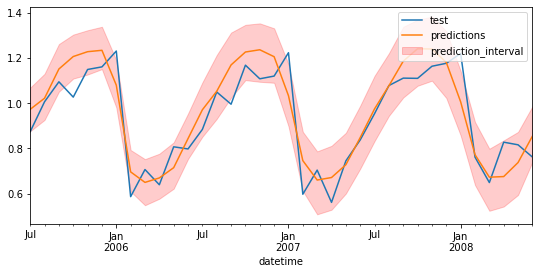

In [5]:
fig, ax=plt.subplots(figsize=(9, 4))
data_test.plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'red',
    alpha = 0.2,
    label = 'prediction_interval'
)
ax.legend(loc='upper right');

## Out of sample residuals

By default, training residuals are used to create the prediction intervals. However, other residuals may be used, for example, residuals obtained from a validation set.

First, the new residuals haver o be stored inside the forecaster using the method `set_out_sample_residuals`.

In [6]:
# Simulated residuals
simulated_residuals = pd.Series(np.random.normal(size=500))
forecaster.set_out_sample_residuals(residuals=simulated_residuals)

Once the new residuals have been added to the forecaster, it is possible to indicate `in_sample_residuals = False` when using its method `predict`.

In [7]:
predictions = forecaster.predict_interval(
                    steps    = 36,
                    interval = [5, 95],
                    n_boot   = 250,
                    in_sample_residuals = False
              )

In [8]:
%%html
<style>
.jupyter-wrapper .jp-CodeCell .jp-Cell-inputWrapper .jp-InputPrompt {display: none;}
</style>